In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import numpy as np
import pandas as pd

# import tqdm.notebook as tq
import tqdm as tq

import random

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]

In [3]:
random_seed = 13

torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [4]:
dataset = 'FordA'

from sktime.datasets import load_UCR_UEA_dataset

X_train, y_train = load_UCR_UEA_dataset(name=dataset, split='train', return_type='numpyflat')
X_test, y_test = load_UCR_UEA_dataset(name=dataset, split='test', return_type='numpyflat')

In [5]:
print(f'Length training data: {len(X_train)} labels: {len(y_train)} test data: {len(X_test)} labels: {len(y_test)}')

Length training data: 3601 labels: 3601 test data: 1320 labels: 1320


In [6]:
encoder = OneHotEncoder(categories='auto', sparse_output=False)

y_train_ohe = encoder.fit_transform(np.expand_dims(y_train, axis=-1))
y_test_ohe = encoder.transform(np.expand_dims(y_test, axis=-1))

y_train_norm = y_train_ohe.argmax(axis=-1)
y_test_norm = y_test_ohe.argmax(axis=-1)

In [7]:
class FordADataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        inputs = self.X[idx]
        label = self.y[idx]
        
        return inputs, label

In [8]:
dataset_train = FordADataset(X_train, y_train_ohe)
dataset_test = FordADataset(X_test, y_test_ohe)

In [9]:
dataloader_train = DataLoader(dataset_train, batch_size=120, shuffle=True)
dataloader_train_not_shuffled = DataLoader(dataset_train, batch_size=120, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=120, shuffle=False)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 10, kernel_size=3, stride=1),
            nn.BatchNorm1d(10),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(10, 50, kernel_size=3, stride=1),
            nn.BatchNorm1d(50),
            nn.MaxPool1d(3),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(50, 50, kernel_size=3, stride=1),
            nn.BatchNorm1d(50),
            nn.MaxPool1d(3),
            nn.ReLU(inplace=True)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 54, 50),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(50, 2),
            nn.Softmax(-1)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [27]:
model = torch.load('models/ford-a-cnn.pth')
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [28]:
model.eval()

preds = []
labels = []
for x in dataloader_train_not_shuffled:
    input_, label_ = x
    input_ = input_.reshape(input_.shape[0], 1, -1)
    input_ = input_.float().to(device)
    label_ = label_.float().to(device)

    pred_ = model(input_)
    preds.extend(pred_)
    labels.extend(label_)

preds = torch.stack(preds)
labels = torch.stack(labels)
print('Prediction Accuracy Train', np.round((preds.argmax(dim=-1) == labels.argmax(dim=-1)).int().sum().float().item() / len(preds), 4))

y_train_pred = preds.cpu().detach().numpy().round(3)

Prediction Accuracy Train 0.9889


In [29]:
model.eval()

preds = []
labels = []
for x in dataloader_test:
    input_, label_ = x
    input_ = input_.reshape(input_.shape[0], 1, -1)
    input_ = input_.float().to(device)
    label_ = label_.float().to(device)

    pred_ = model(input_)
    preds.extend(pred_)
    labels.extend(label_)

preds = torch.stack(preds)
labels = torch.stack(labels)
print('Prediction Accuracy Test', np.round((preds.argmax(dim=-1) == labels.argmax(dim=-1)).int().sum().float().item() / len(preds), 4))

y_test_pred = preds.cpu().detach().numpy().round(3)

Prediction Accuracy Test 0.9121


# Save results as json

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import exp_perturbation_analysis as exp_pa

import exp_stability_indicator as exp_si

import exp_plots as exp_pl

import scipy as sp

In [32]:
from captum.attr import GradientShap, DeepLiftShap, IntegratedGradients, ShapleyValueSampling, Saliency, DeepLift

In [33]:
import matplotlib as mpl

cmap = 'tab10'

In [34]:
attribution_measure = exp_si.attribution_stability_indicator
get_asi_for_dataset = exp_si.get_asi_for_dataset

In [35]:
sample_idx = 3
sample_ts_np, sample_l = dataloader_test.dataset[sample_idx]

sample, label = dataset_train[0]
shape = sample_ts_np.reshape(1, -1).shape

baselines = torch.from_numpy(np.array([dataset_test[torch.randint(len(dataset_test), (1,))][0] for _ in range(10)])).reshape(-1, *shape).float().to(device)



attribution_techniques = [
    ['Saliency', Saliency, {}],
    ['GradientShap', GradientShap, {'baselines': baselines}],
    
    ['DeepLift', DeepLift, {}],
    ['DeepLiftShap', DeepLiftShap, {'baselines': baselines}],
    
    ['IntegratedGradients', IntegratedGradients, {}],
    
#     ['ShapleyValueSampling', ShapleyValueSampling, {}],
]


asi_results = {}


for at in tq.tqdm(attribution_techniques):
    at_name, at_class, at_kwargs = at
    asi_results[at_name] = attribution_measure(model, sample_ts_np, sample_l, at_class, at_kwargs, debug=True, weights=[0.5, 1, 0.5, 3], perturbation_fnc=exp_pa.delete_to_zero)

  0%|          | 0/5 [00:00<?, ?it/s]/home/schlegel/.conda/captum/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/schlegel/.conda/captum/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
100%|██████████| 5/5 [00:00<00:00, 35.11it/s]

XAI: Saliency
Original Pred:  [0. 1.]
Perturbed Pred: [0.982363 0.017637]

TS Correl: 0.06167615277257554
Att Correl: 0.5670566063549951

Labels
TL  P1  Pd
 1   1   0

ASI
0.35293

XAI: GradientShap
Original Pred:  [0. 1.]
Perturbed Pred: [1. 0.]

TS Correl: 0.1284077447359161
Att Correl: 0.5300850968963605

Labels
TL  P1  Pd
 1   1   0

ASI
0.33089

XAI: DeepLift
Original Pred:  [0. 1.]
Perturbed Pred: [1. 0.]

TS Correl: 0.22274077366716405
Att Correl: 0.5427125882616746

Labels
TL  P1  Pd
 1   1   0

ASI
0.3479

XAI: DeepLiftShap
Original Pred:  [0. 1.]
Perturbed Pred: [1. 0.]

TS Correl: 0.214662923942883
Att Correl: 0.5555262364523158

Labels
TL  P1  Pd
 1   1   0

ASI
0.35478

XAI: IntegratedGradients
Original Pred:  [0. 1.]
Perturbed Pred: [1. 0.]

TS Correl: 0.2737310337426986
Att Correl: 0.5312123350272819

Labels
TL  P1  Pd
 1   1   0

ASI
0.3461



In [45]:
from scipy.stats import zscore

def norm(data):
    return (data - min(data)) / (max(data) - min(data))

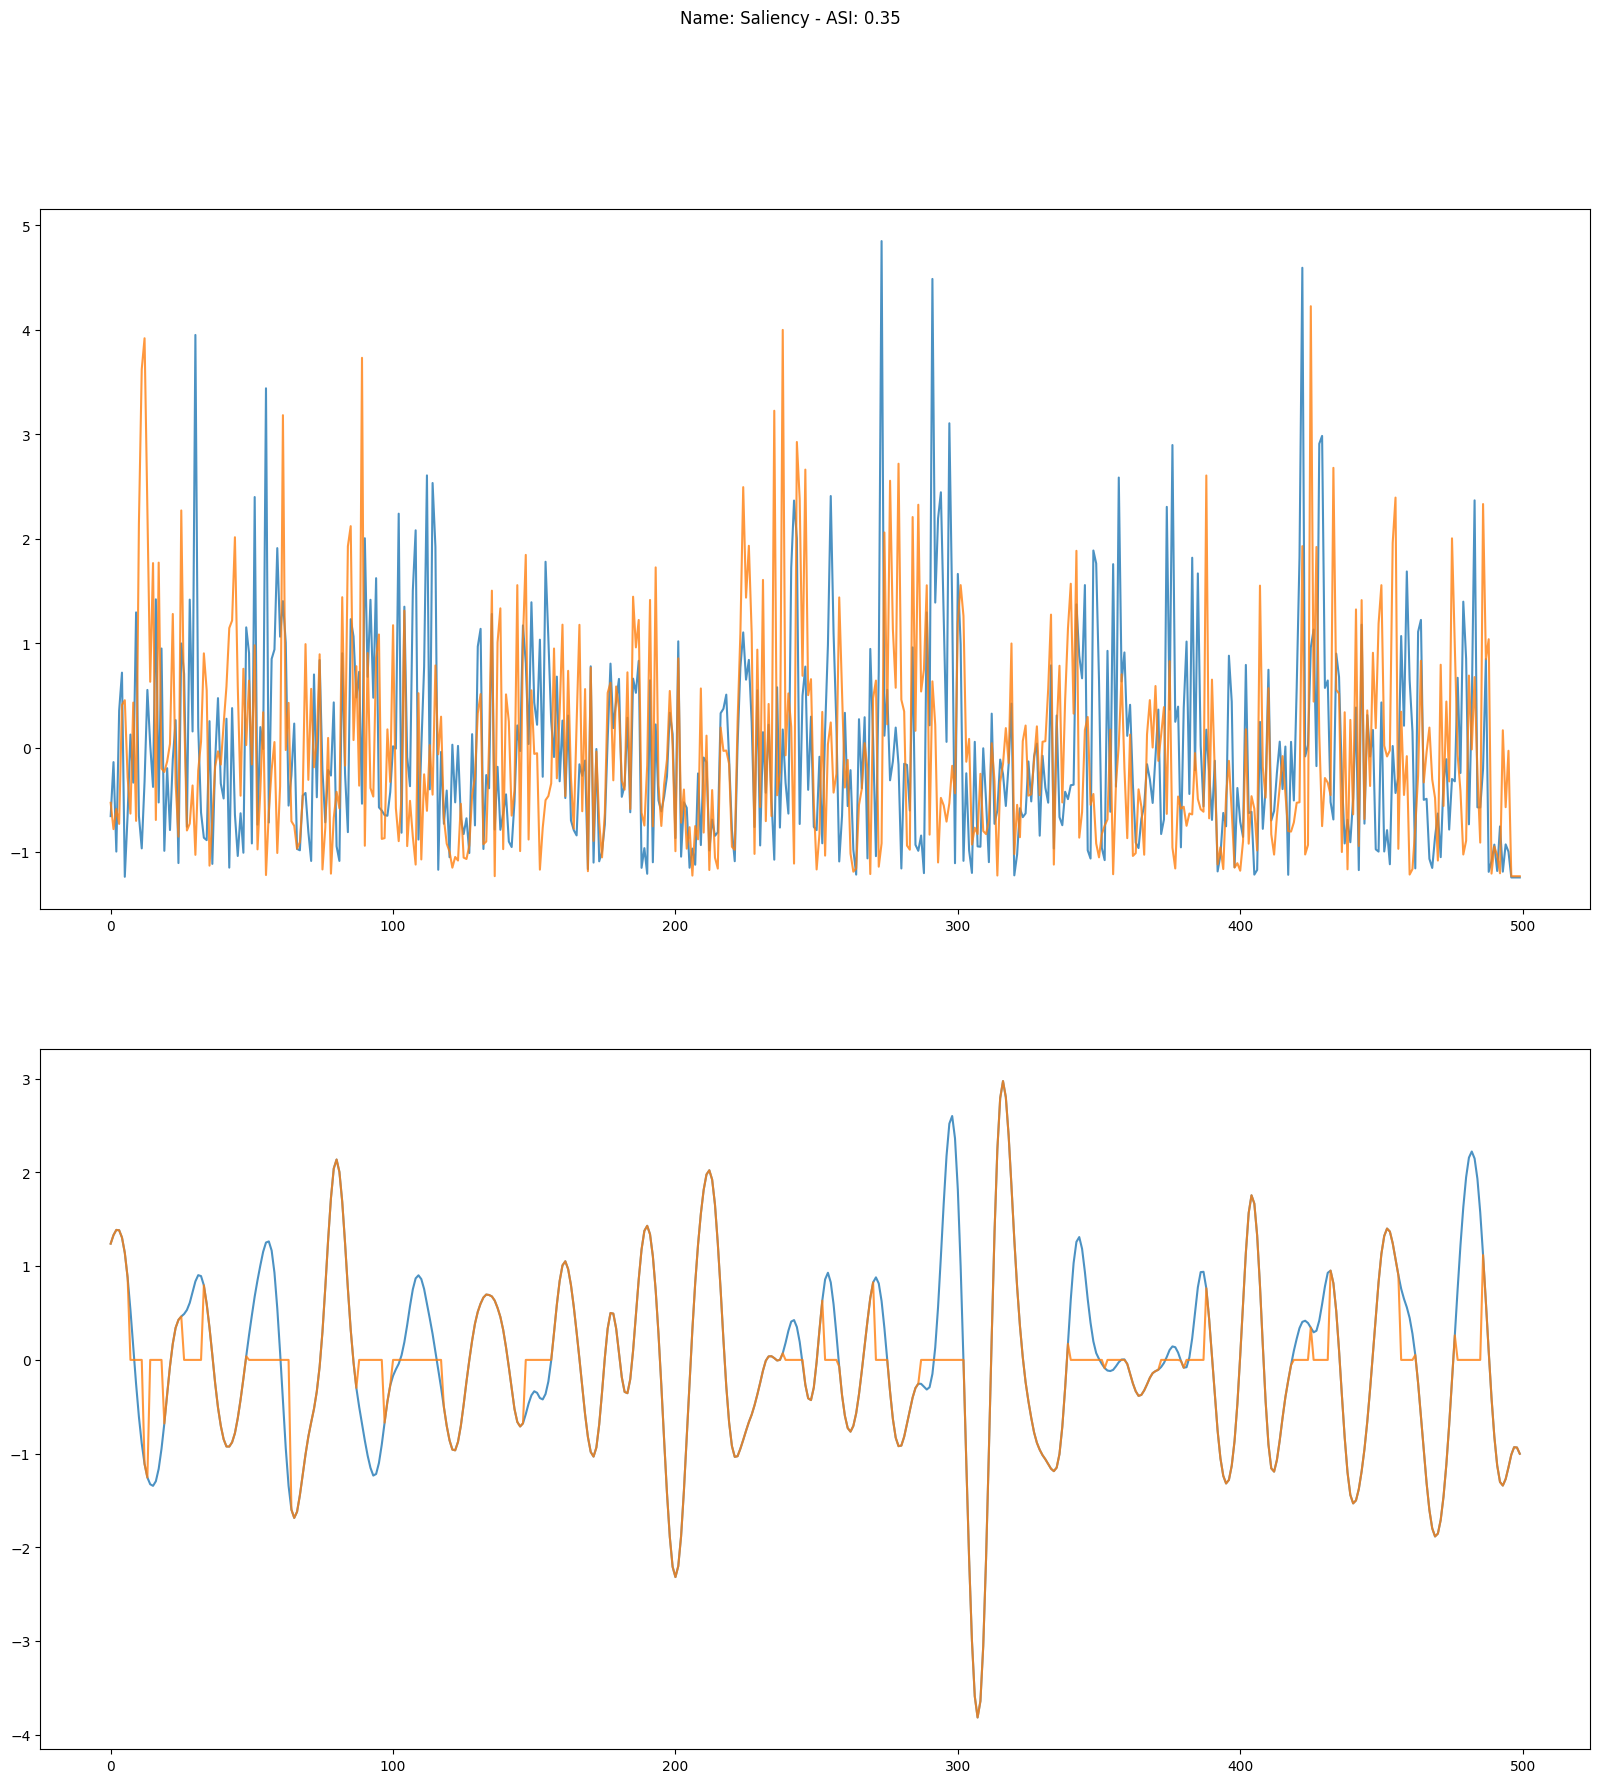

ASI: 0.35 - TS-PCC: 0.06 - ATT-PCC: 0.57 - ATT-PCC-NORM 0.57


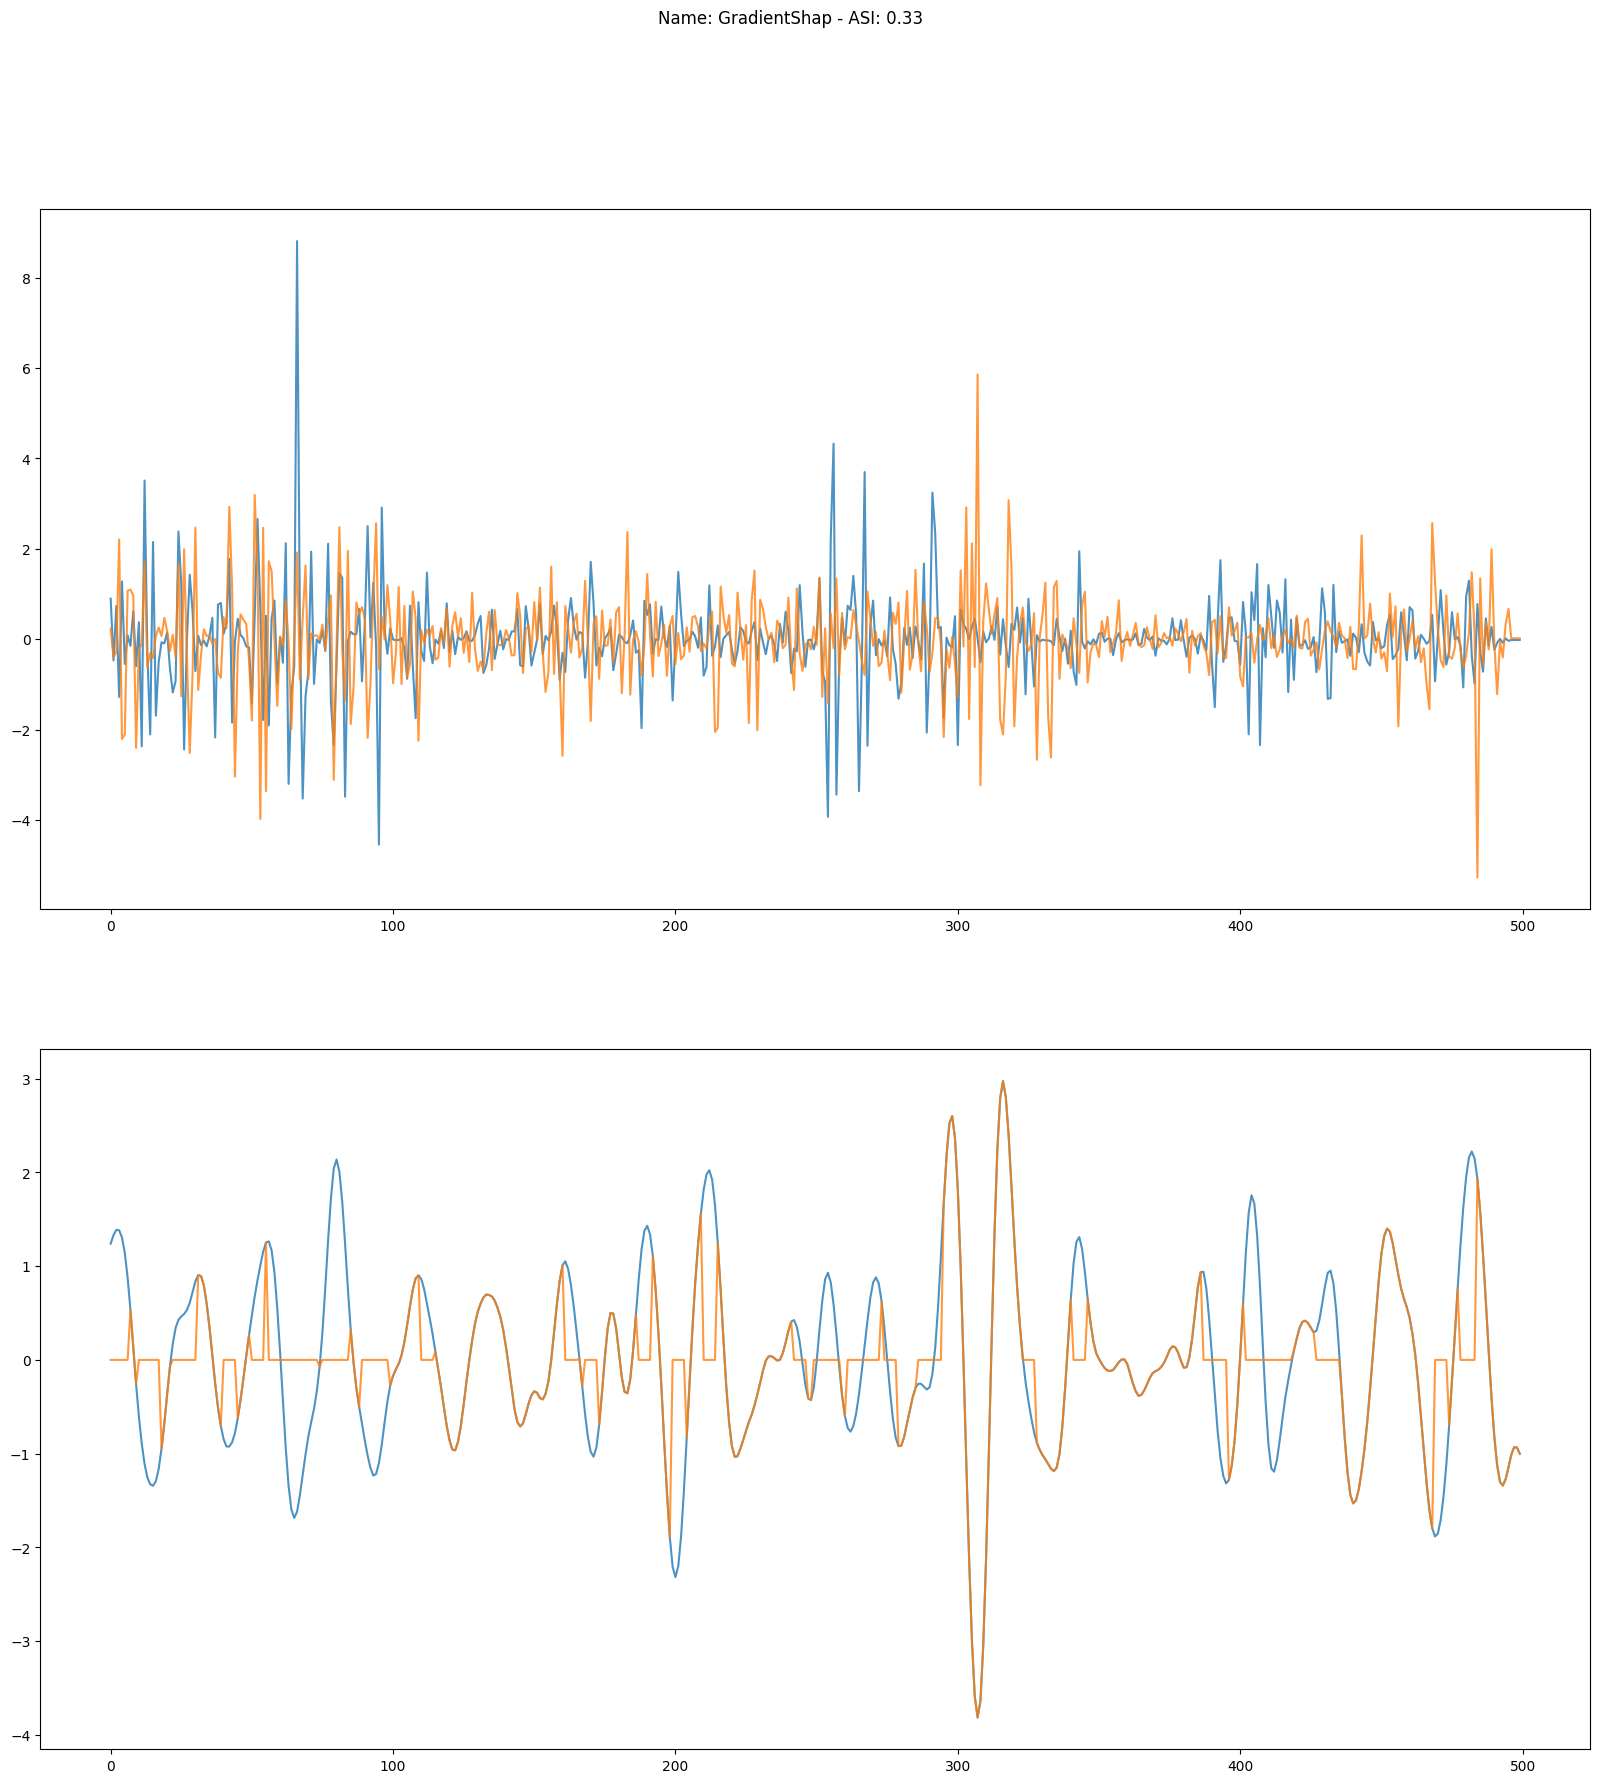

ASI: 0.33 - TS-PCC: 0.13 - ATT-PCC: 0.53 - ATT-PCC-NORM 0.53


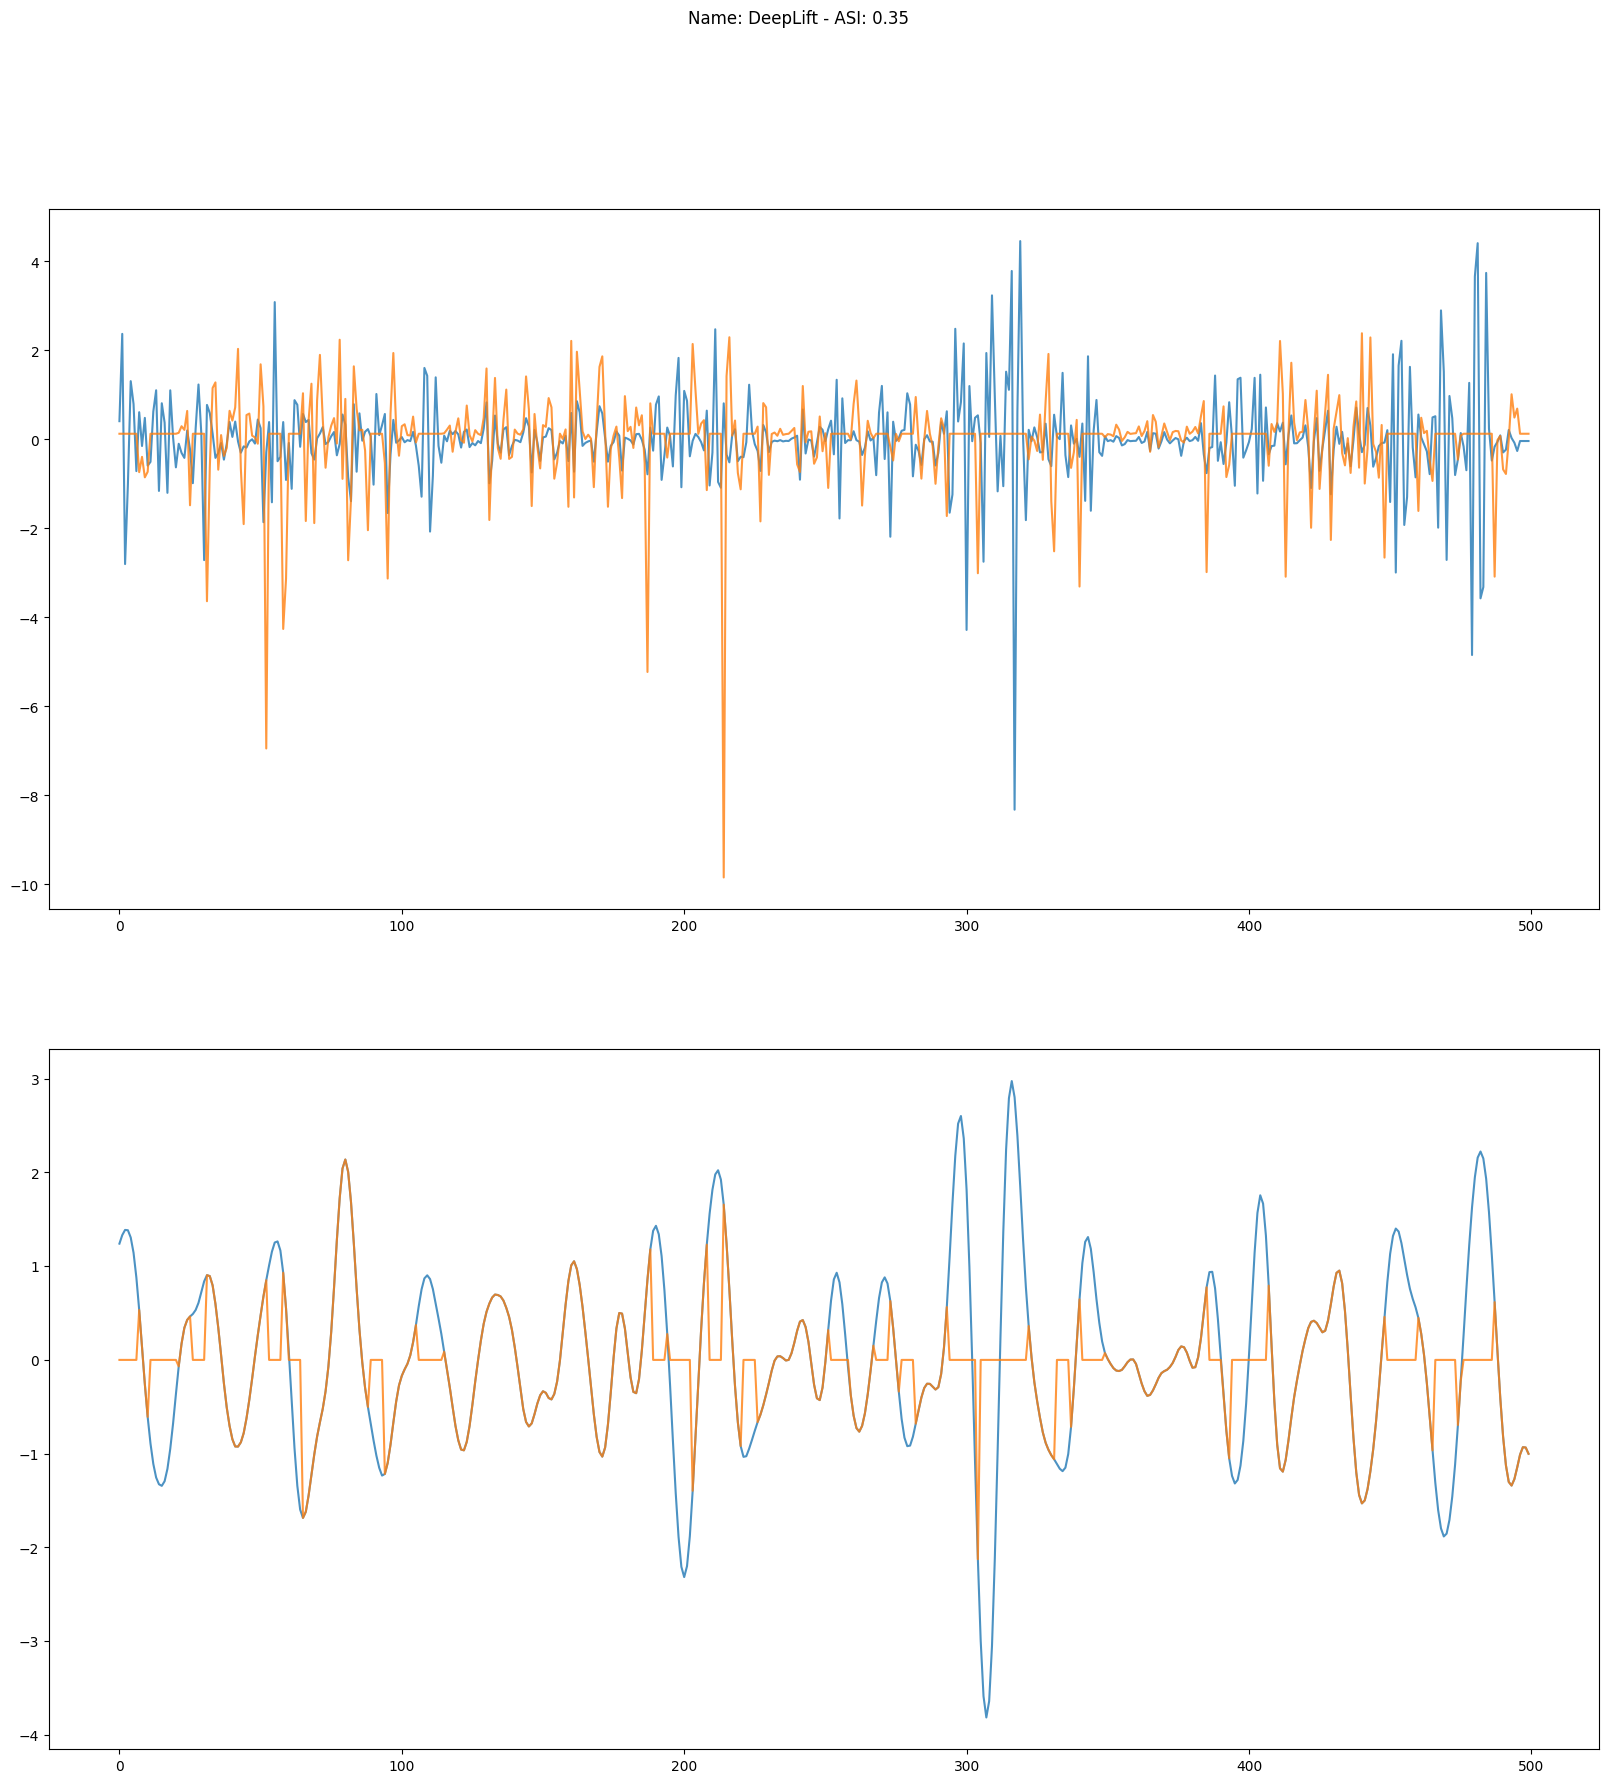

ASI: 0.35 - TS-PCC: 0.22 - ATT-PCC: 0.54 - ATT-PCC-NORM 0.54


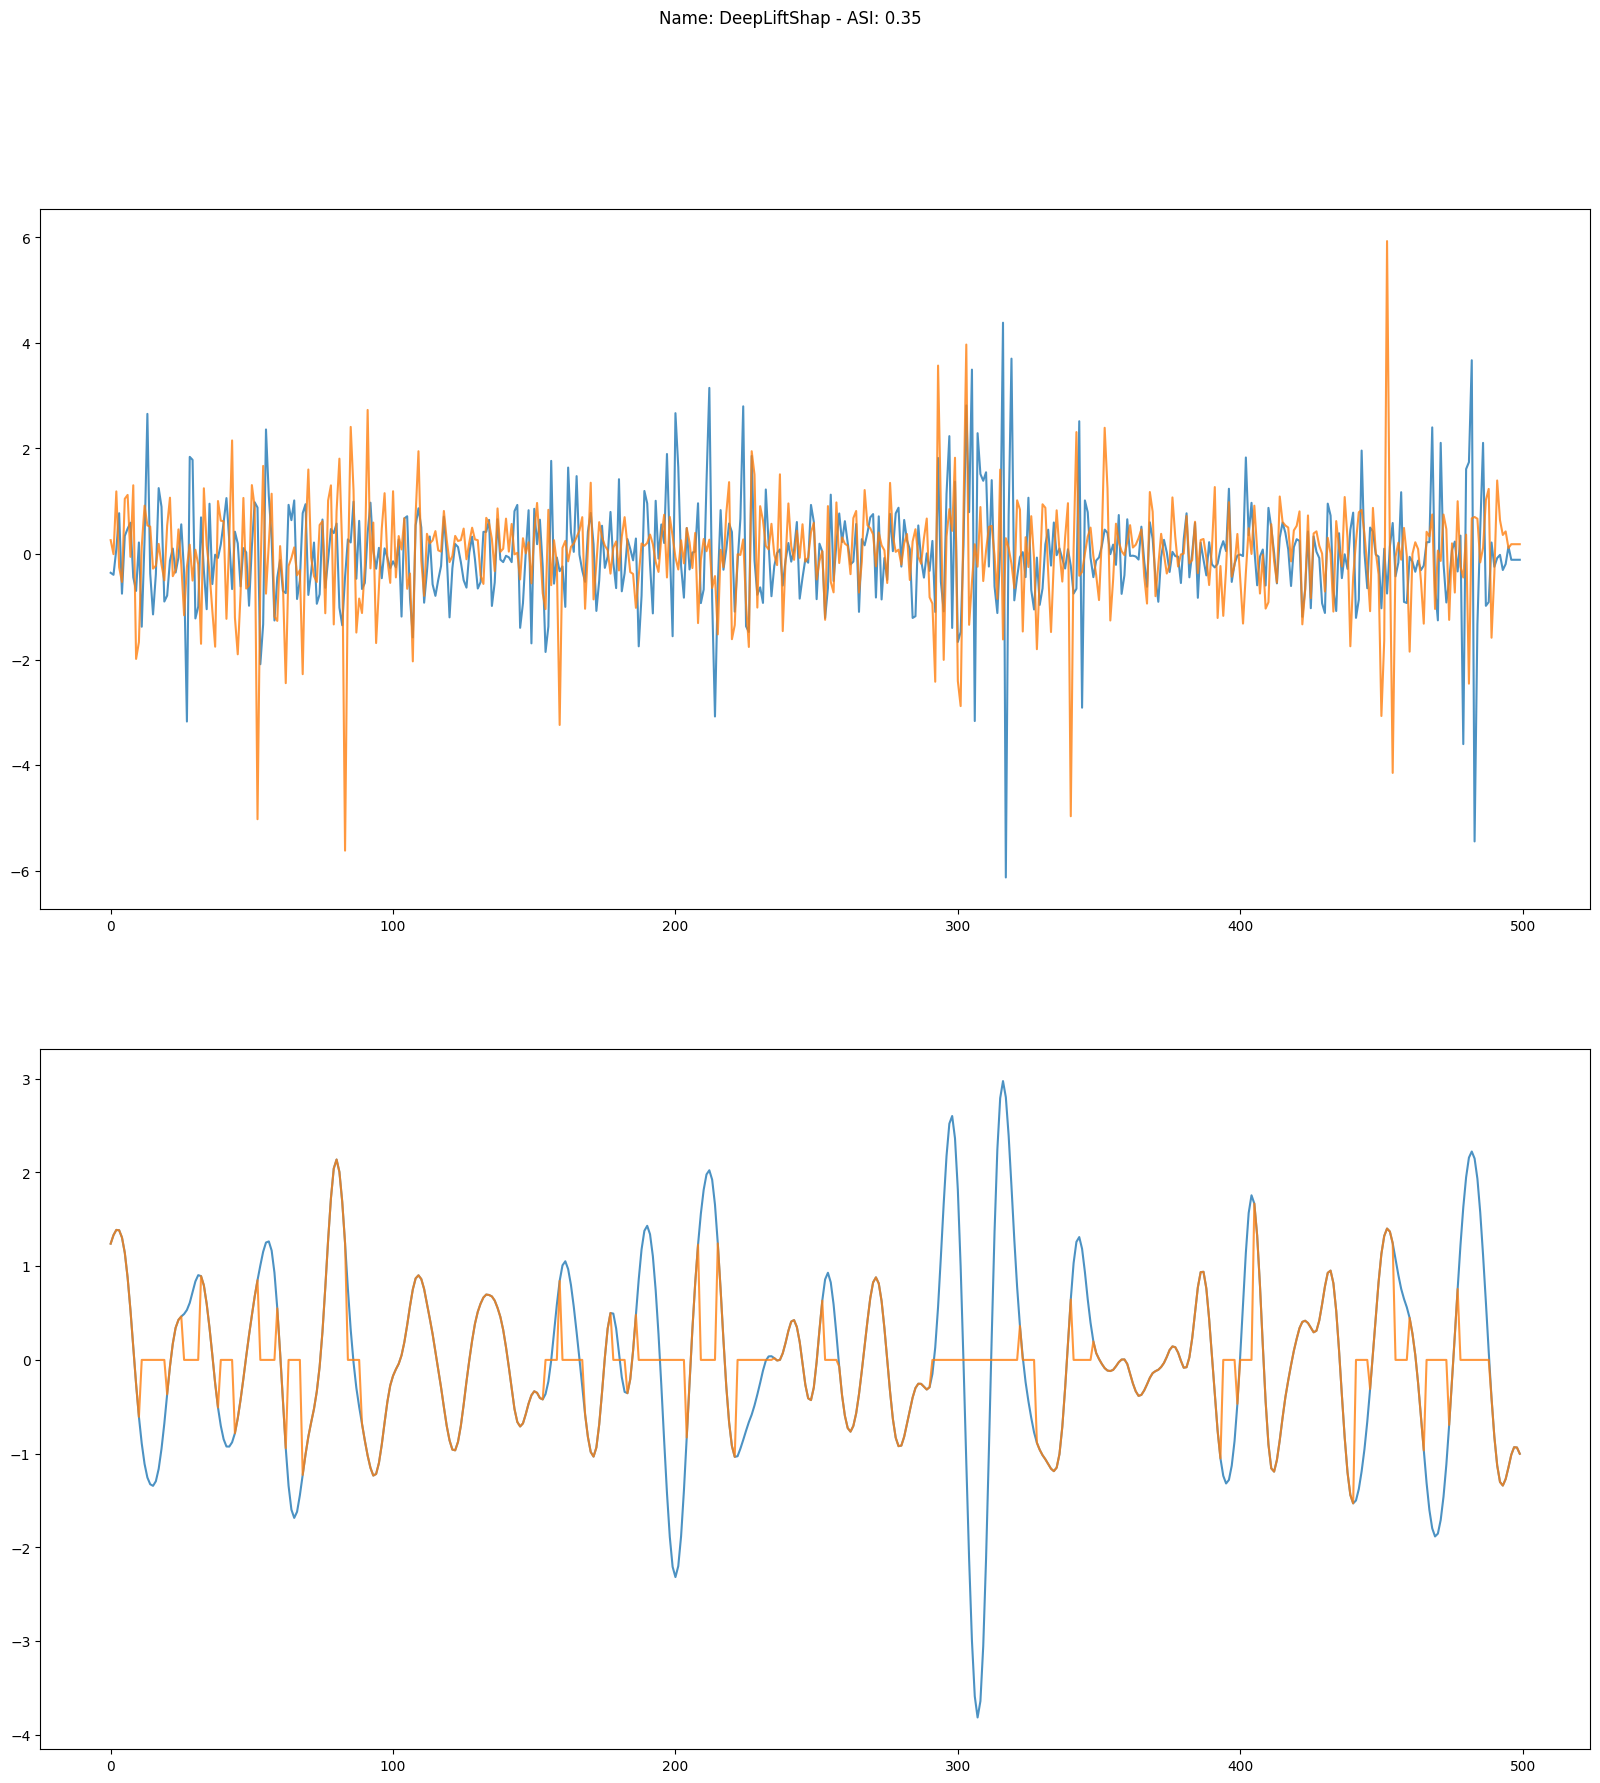

ASI: 0.35 - TS-PCC: 0.21 - ATT-PCC: 0.56 - ATT-PCC-NORM 0.56


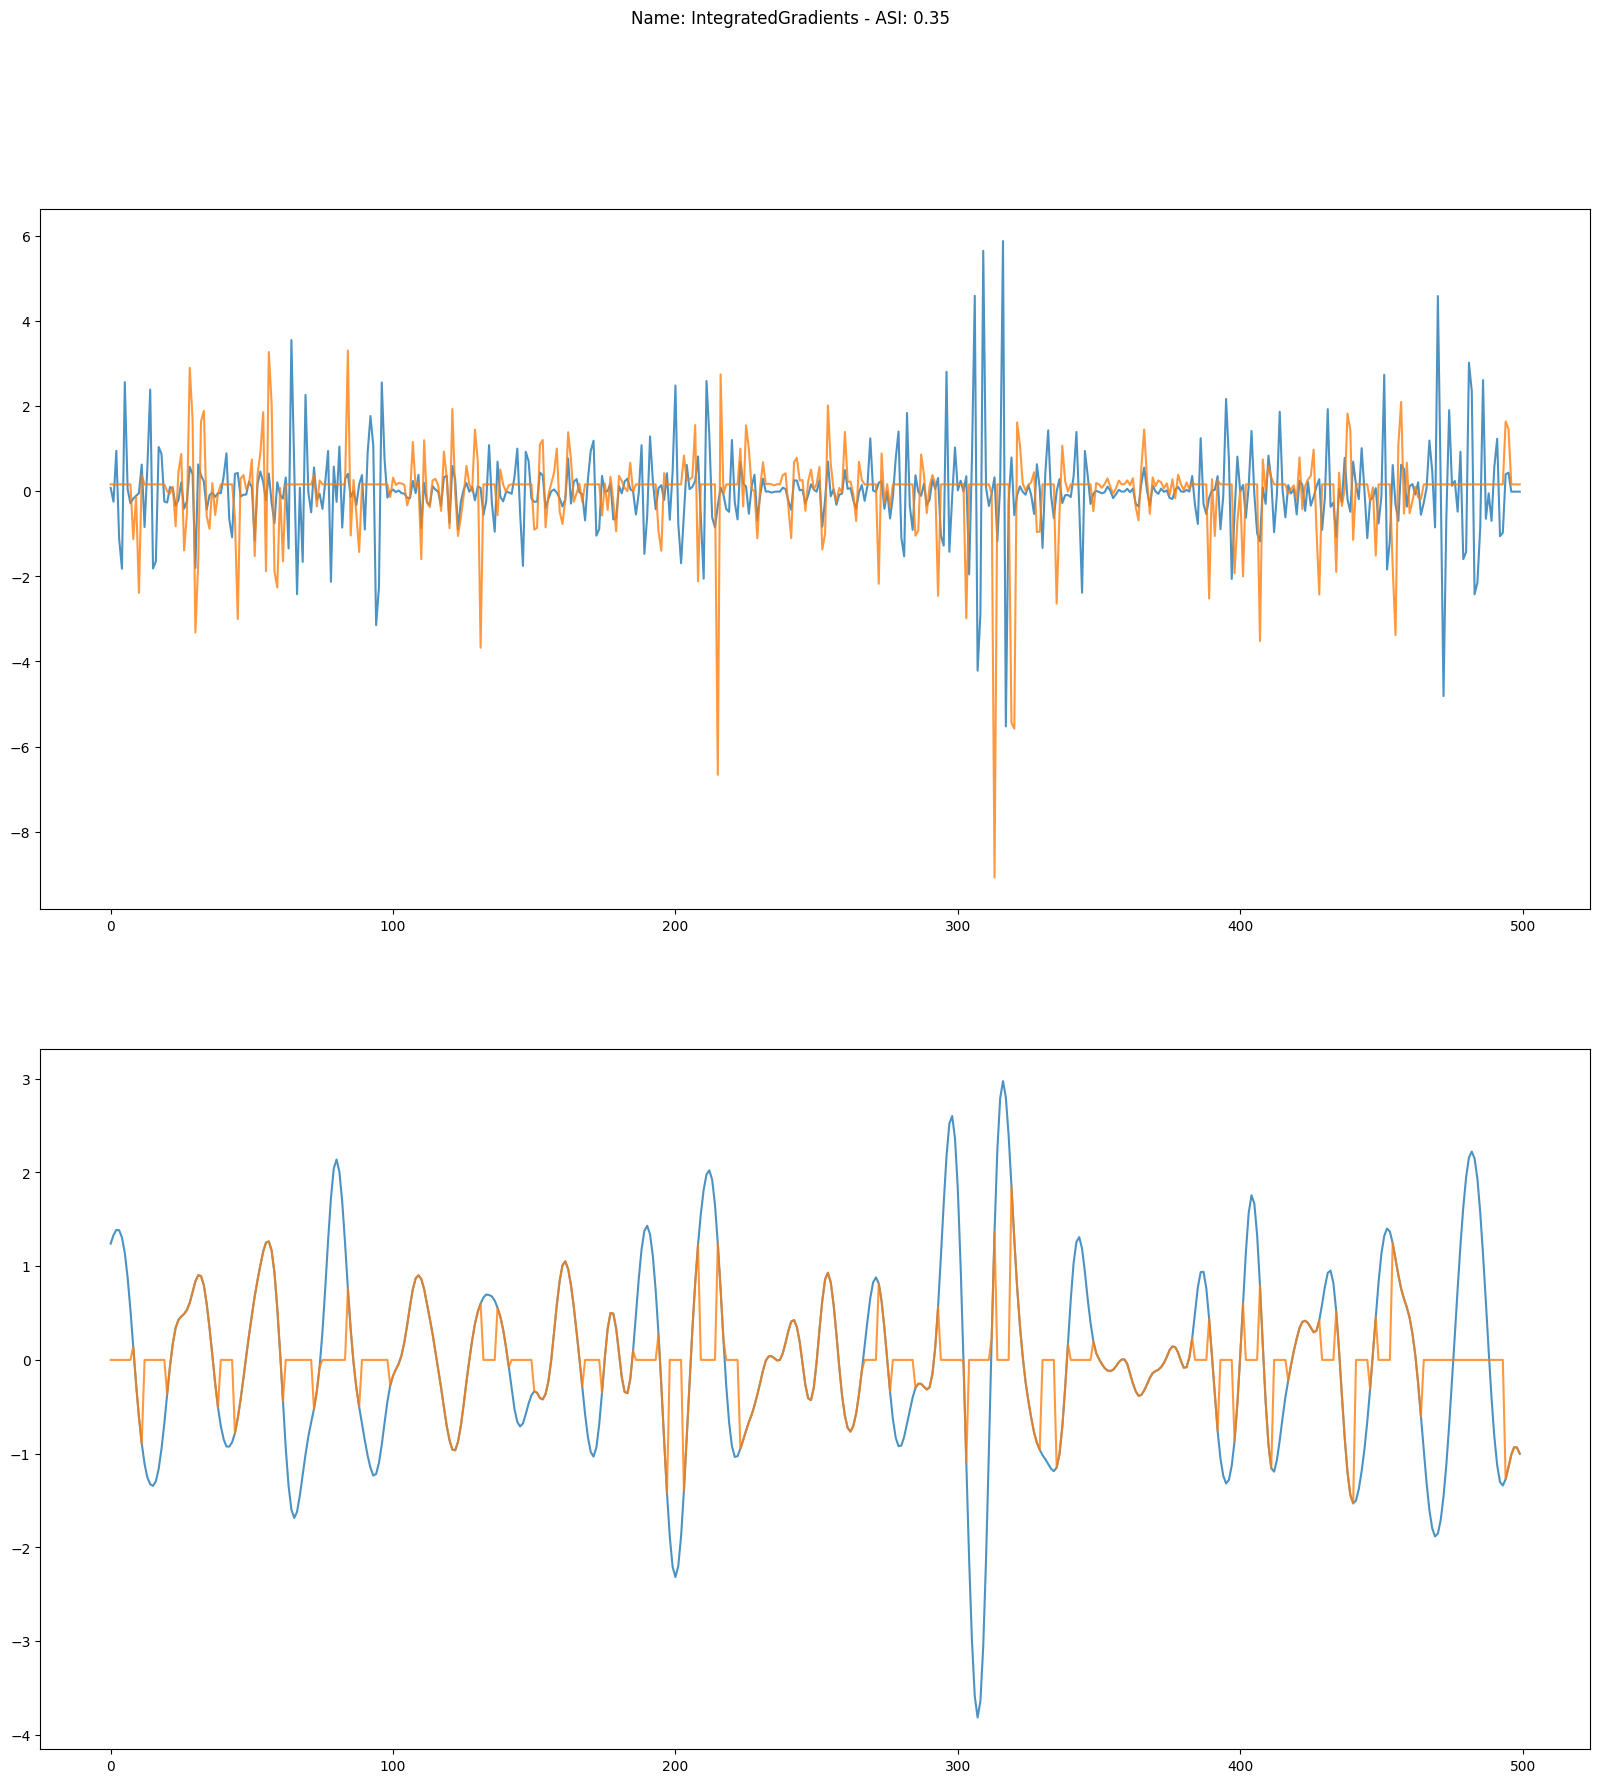

ASI: 0.35 - TS-PCC: 0.27 - ATT-PCC: 0.53 - ATT-PCC-NORM 0.53


In [47]:
alpha = 0.8

for k in asi_results:
    
    name = k
    score = asi_results[k][0]
    
    att_old = asi_results[k][1]
    att_new = asi_results[k][3]
    
    plt.figure(figsize=[20, 20])
    plt.suptitle(f'Name: {name} - ASI: {score:.2f}')
    
    plt.subplot(2, 1, 1)
    plt.plot(zscore(norm(att_old)), alpha=alpha)
    plt.plot(zscore(norm(att_new)), alpha=alpha)
    
    plt.subplot(2, 1, 2)
    ts_pert_del, deleted = exp_pa.deletion_sequence(sample_ts_np, att_old, np.percentile(att_old, 90), exp_pa.delete_to_zero(ts=sample_ts_np), 5)
    plt.plot(sample_ts_np, alpha=alpha)
    plt.plot(ts_pert_del, alpha=alpha)
    
    plt.show()
    
    att_pcc = exp_si.correlation_distances(att_old, att_new)
    att_pcc_norm = exp_si.correlation_distances(zscore(norm(att_old)), zscore(norm(att_new)))
    ts_pcc = 1 - exp_si.correlation_distances(sample_ts_np, ts_pert_del)
    print(f'ASI: {score:.2f} - TS-PCC: {ts_pcc:.2f} - ATT-PCC: {att_pcc:.2f} - ATT-PCC-NORM {att_pcc_norm:.2f}')

# Attribution weights

0.0
422.00371817539013 430.23089317668996 438.9187937784058
634 632 630
0.5
553.0671490462561 591.984966323552 595.9886274066998
634 632 630
1.0
684.1305799170988 753.7390394716755 753.0584610349916
634 632 630
1.5
815.1940107879138 915.4931126180385 910.1282946632842
634 632 630
2.0
946.2574416587993 1077.2471857656694 1067.1981282915788
634 632 630
2.5
1077.320872529592 1239.0012589124929 1224.267961919873
634 632 630
3.0
1208.3843034004103 1400.755332059515 1381.337795548166
634 632 630
3.5
1339.447734271323 1562.5094052070085 1538.407629176456
634 632 630

# Time Series weights
0.0
865.3448266426695 1003.8939259848244 993.5196011919537
634 632 630
0.5
905.8011341505498 1040.5705558737616 1030.3588647417655
634 632 630
1.0
946.2574416586899 1077.2471857633745 1067.1981282915788
634 632 630
1.5
986.7137491669238 1113.923815655598 1104.0373918413875
634 632 630
2.0
1027.1700566747918 1150.6004455429602 1140.8766553912005
634 632 630
2.5
1067.6263641826677 1187.2770754348387 1177.7159189410138
634 632 630
3.0
1108.0826716907757 1223.953705320959 1214.5551824908255
634 632 630
3.5
1148.5389791988503 1260.6303352114264 1251.394446040634
634 632 630

# Argmax

0.0
774.7574416587389 897.8721857635575 883.3231282915788
634 632 630
0.5
860.5074416587198 987.5596857659607 975.2606282915785
634 632 630
1.0
946.257441658484 1077.2471857661833 1067.1981282915788
634 632 630
1.5
1032.007441658797 1166.934685765169 1159.1356282915788
634 632 630
2.0
1117.7574416586285 1256.6221857659527 1251.0731282915788
634 632 630
2.5
1203.5074416585023 1346.3096857645014 1343.0106282915779
634 632 630
3.0
1289.2574416587527 1435.997185766185 1434.9481282915783
634 632 630
3.5
1375.00744165852 1525.6846857640899 1526.8856282915779
634 632 630

In [42]:
loader = dataloader_train_not_shuffled
asi_full_results = get_asi_for_dataset(loader, model, attribution_techniques, [0.5, 1, 0.5, 3], exp_pa.ood_l)

  0%|          | 0/3601 [00:00<?, ?it/s]/home/schlegel/.conda/captum/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/schlegel/.conda/captum/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
100%|██████████| 3601/3601 [10:53<00:00,  5.51it/s]


In [43]:
import umap.umap_ as umap_

Saliency 1864.8646040243666


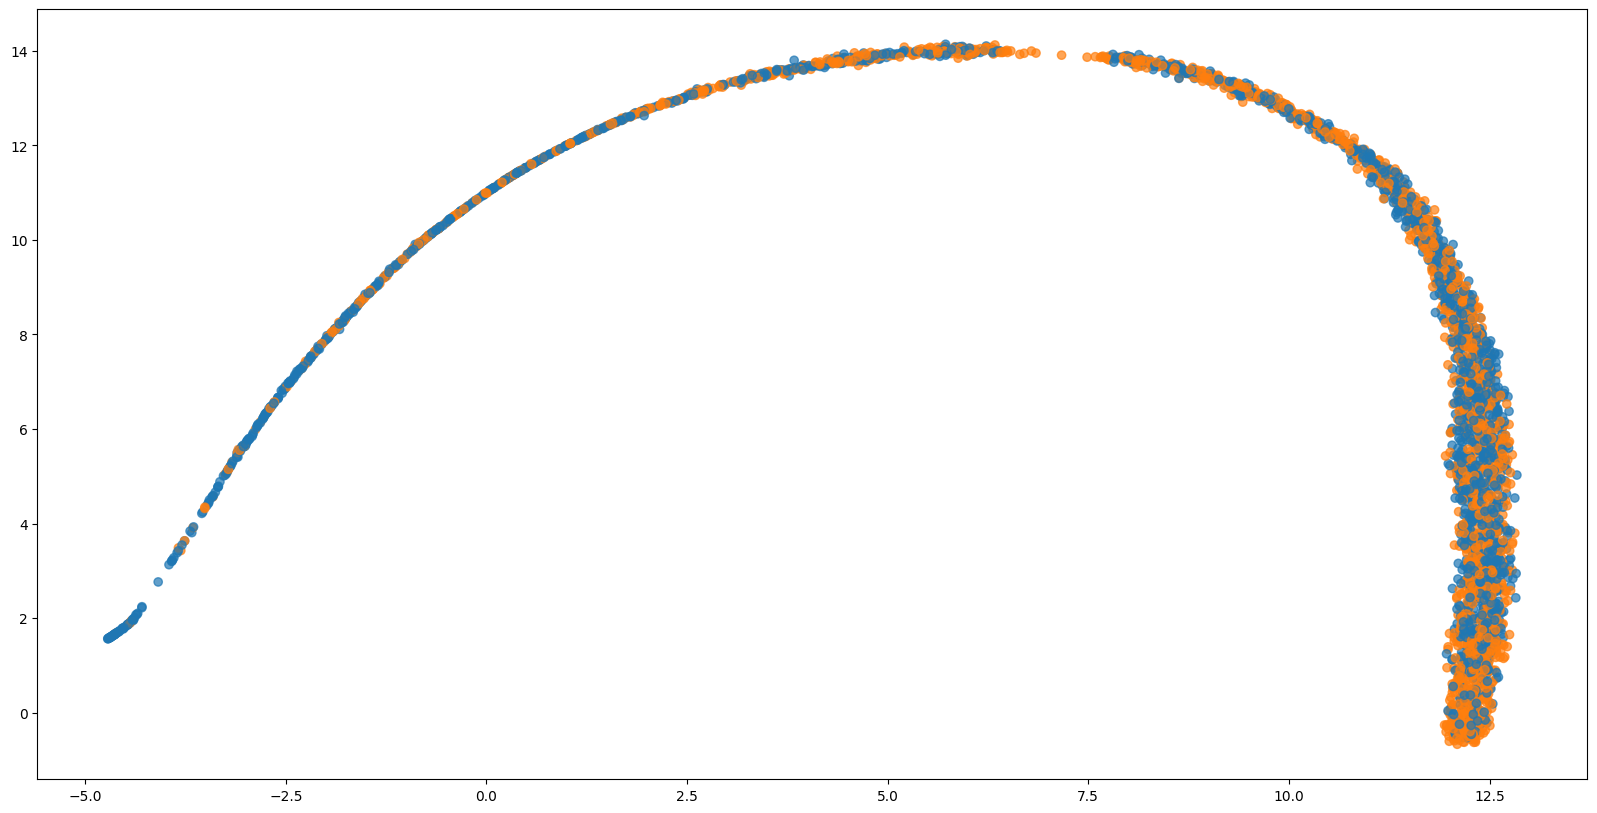

GradientShap 1936.3984198289095


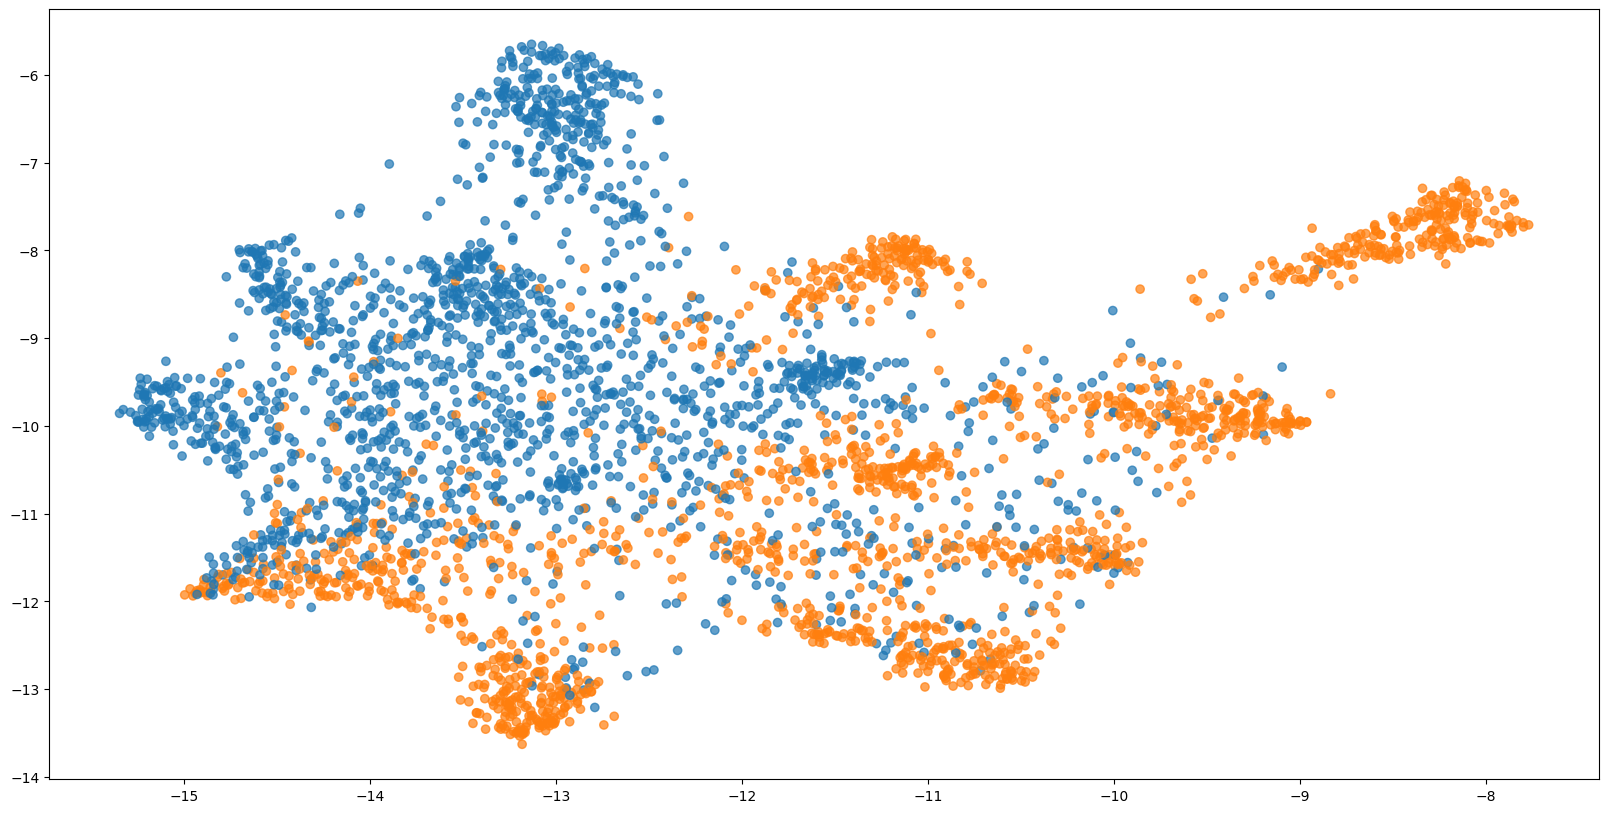

DeepLift 2072.6466818304843


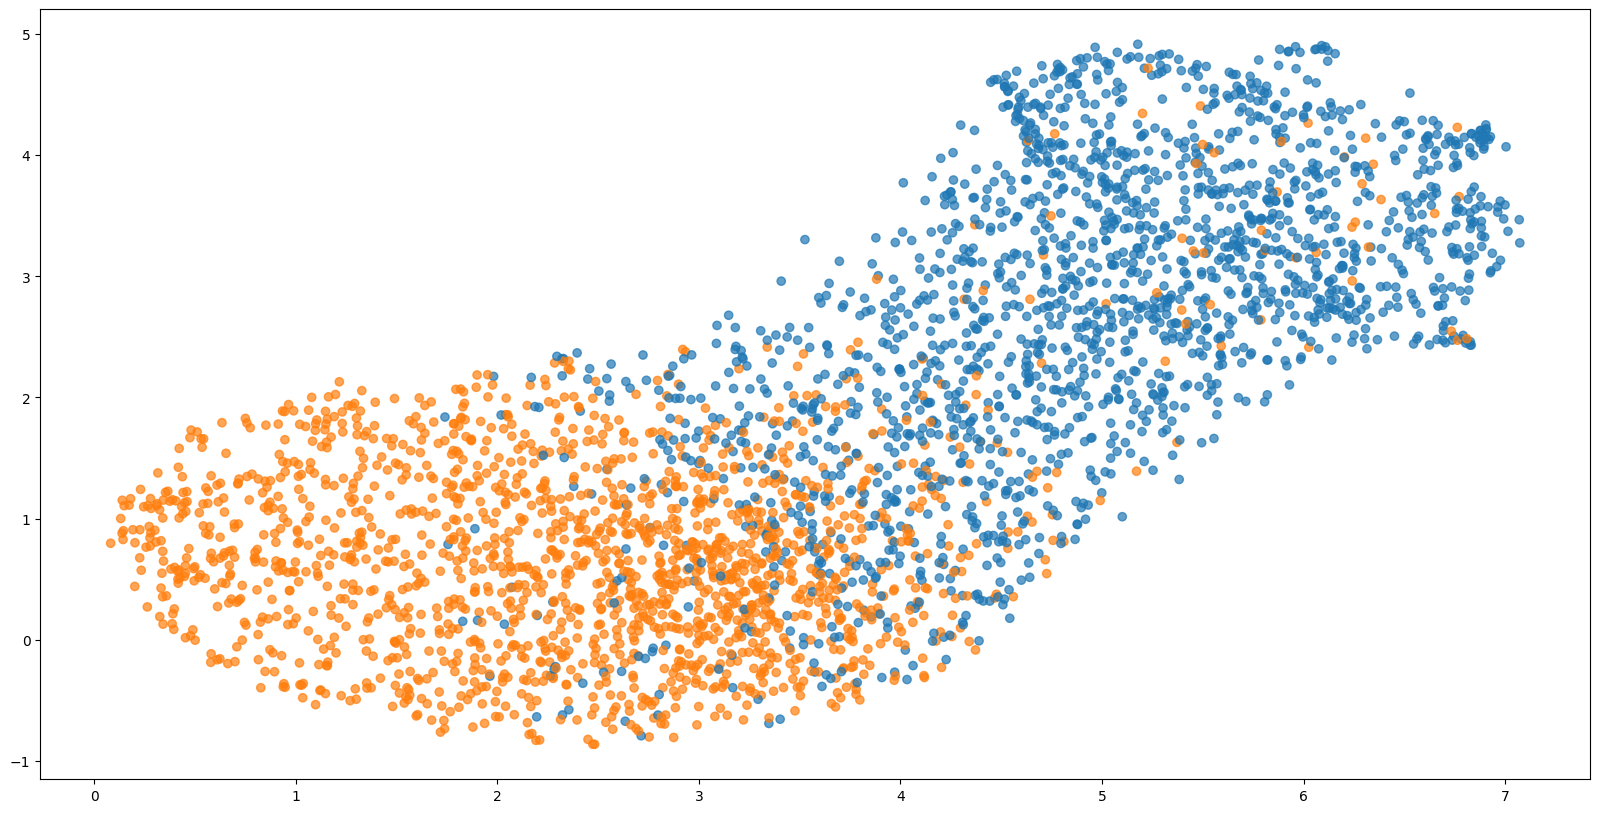

DeepLiftShap 2006.9620617526946


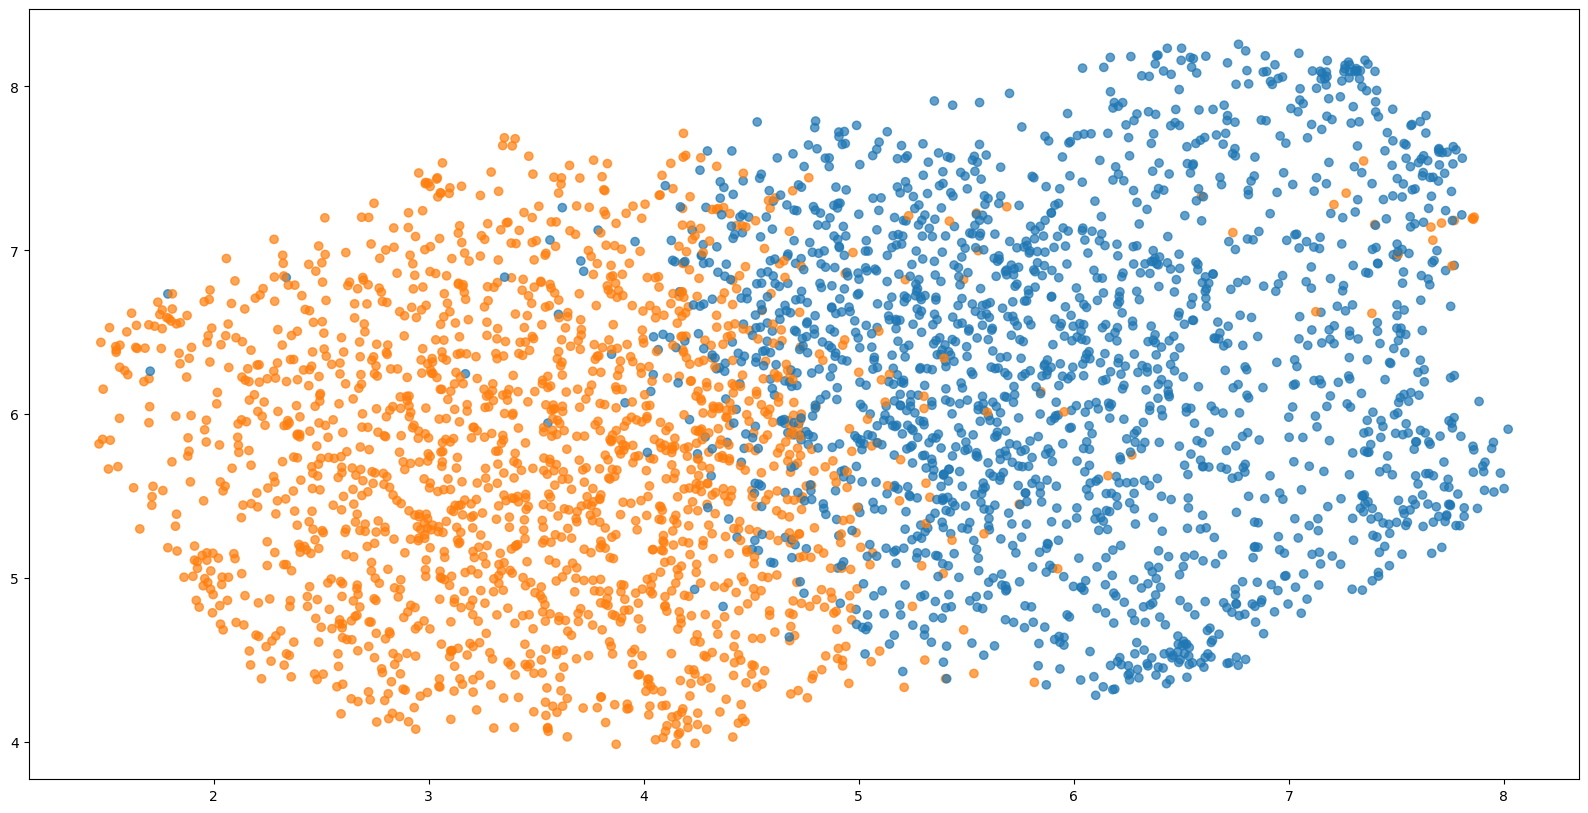

IntegratedGradients 2079.852374095093


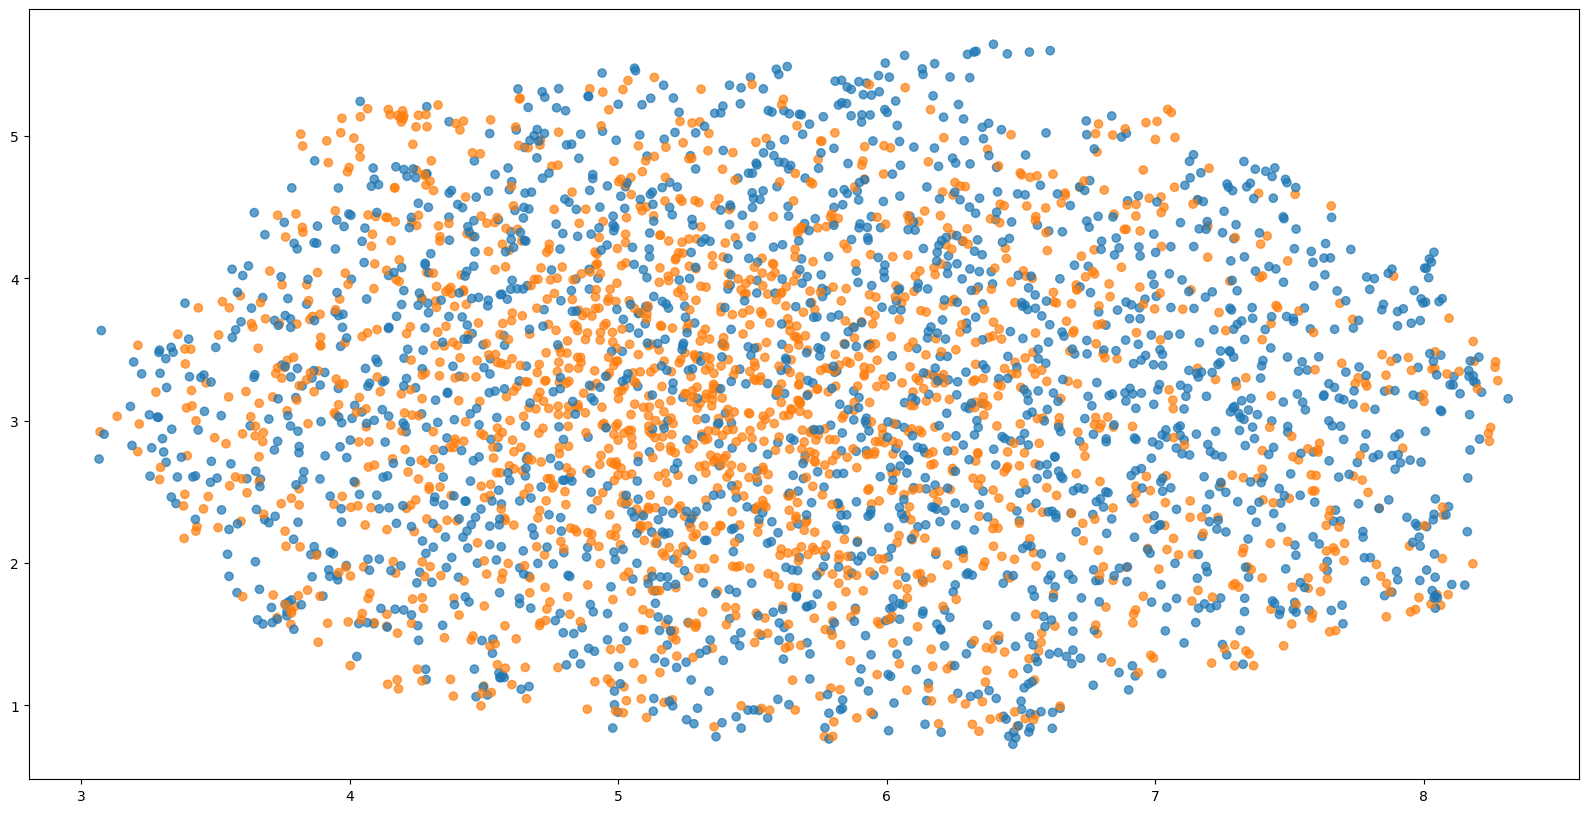

In [44]:
cmap='tab10'

for k in asi_full_results:
    score = np.sum([x[0] for x in asi_full_results[k]])
    print(k, score)
    data = np.array([x[1] for x in asi_full_results[k]])
    
    colors = np.array([x[2] for x in asi_full_results[k]])[:,0]
    colors_mapped = np.array([mpl.colormaps[cmap](x) for x in colors])

    umap_reducer = umap_.UMAP(random_state=13)
    umap_data = umap_reducer.fit_transform(data)

    plt.figure(figsize=(20,10))
    scatter = plt.scatter(umap_data[:,0], umap_data[:,1], c=colors_mapped, alpha=0.7)
    plt.show()